# Fundamentals of Machine Learning
# Exercise 03.2 Naive Bayes Classifier

In [92]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import iqr
np.seterr(divide='ignore', invalid='ignore')
RANDOMSEED = 348123 # For reproducability
# k-fold instance for cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOMSEED)

# Data preparation

In [97]:
# load data
digits = load_digits()
print(f"Dataset size: {len(digits.data)}")

# filter for digits 3 & 9
mask = (digits.target == 3) | (digits.target == 9)
# normalize data
x_data = digits.data[mask]/digits.data.max()
y_labels = digits.target[mask]
print(f"Filtered dataset size (only label 3 & 9): {len(x_data)}")
mask1 = y_labels == 3
mask2 = y_labels == 9

Dataset size: 1797
Filtered dataset size (only label 3 & 9): 363


### Feature reduction

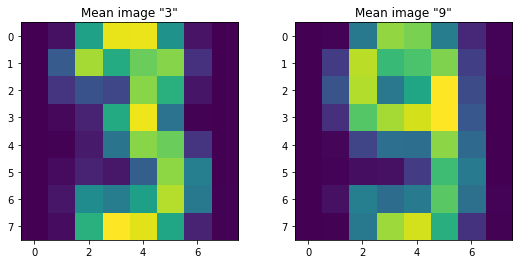

In [107]:
# calculate and plot means to find good features
fig, ax = plt.subplots(1,2, figsize=(9, 4))
mean1 = np.mean(x_data[mask1], axis=0)
mean2 = np.mean(x_data[mask2], axis=0)
ax[0].imshow(mean1.reshape(8,8))
ax[0].set_title('Mean image "3"')
ax[1].imshow(mean2.reshape(8,8))
ax[1].set_title('Mean image "9"')

# Use mean of rows 3 and 4 as feature
def reduce_dim(x):
    out = np.empty((x.shape[0], 2))
    for i in range(x.shape[0]):
        out[i] = np.array( [np.mean(x[i, 24:32]), np.mean(x[i, 32:40])] )
    return out

# reduce all feature data
x_features = reduce_dim(x_data)

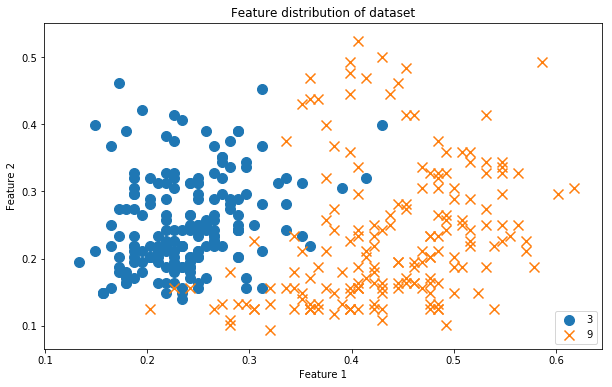

In [110]:
# plot features of data and label with marker/color
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x_features[mask1,0], x_features[mask1,1], marker='o', label='3', s=100)
ax.scatter(x_features[mask2,0], x_features[mask2,1], marker='x', label='9', s=100)
ax.set_title("Feature distribution of dataset")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend(loc='lower right');

# Implementation

## Fitting

In [74]:
def fit_naive_bayes(features, labels, bincount=0):
    possible_labels = np.unique(labels)
    C = len(possible_labels)
    D = features.shape[1]
    
    # find good bincount if not provided
    if bincount == 0:
        for i, label in enumerate(possible_labels):
            mask = labels == label
            # find features ranges
            range_ = np.max(features[mask], axis=0) - np.min(features[mask], axis=0)
            # Freedman-Diaconis rule
            dx = 2 * iqr(features[mask], axis=0) / features[mask].shape[0]**(1/3)
            # filter out empty features for binsize selection
            dx_filter = dx != 0
            # calculate bincount from binsize and range
            binc = int(np.max(np.ceil(range_[dx_filter] / dx[dx_filter])))
            # find max bincount for all features and classes
            if binc > bincount:
                bincount = binc
    
    histograms = np.empty((C, D, bincount))
    binning = np.empty((C, D, 2))
    
    # for every class and feature
    for i, label in enumerate(possible_labels):
        mask = labels == label
        for j in range(D):
            # find histogram binning parameters
            min_ = np.min(features[mask,j])
            dx = (np.max(features[mask,j]) - min_) / bincount
            binning[i, j] = np.array([min_, dx])
            # calculate histograms
            histograms[i,j], _ = np.histogram(features[mask,j], bins=bincount, density=True)
    
    return histograms, binning

## Prediction

In [93]:
def predict_naive_bayes(test_features, histograms, binning, possible_labels=[3,9]):
    scores = np.empty((histograms.shape[0], test_features.shape[0]))
    # for every class, calculate score
    for k in range(binning.shape[0]):
        # find bin indices for all features
        bin_indices = np.floor((test_features - binning[k,:,0])/binning[k,:,1]).astype(int)
        # bin index out of range handling
        bin_indices[bin_indices < 0] = 0
        bin_indices[bin_indices >= histograms.shape[2]] = histograms.shape[2]-1
        # get probabilities from histogram
        probs = np.array([histograms[k, j, bin_indices[:,j]] for j in range(test_features.shape[1])])
        # calculate score
        scores[k] = np.sum(np.log(probs), axis=0)
    # find max score and replace class index with label
    return np.fromiter((possible_labels[k] for k in np.argmax(scores, axis=0)), dtype='int')

### Confusion Matrix

In [115]:
def confusion_matrix(predicted, truth, nice_print=False, labels=[3,9]):
    conf = np.empty((len(labels), len(labels)), dtype='int')
    # calculate decision matrix
    for i, label in enumerate(labels):
        _, conf[i] = np.unique(predicted[truth == label], return_counts=True)
    
    # print confusion matrix using pandas
    if nice_print:
        display(pd.DataFrame(data = conf, index=labels, columns=labels).rename_axis("Truth/Predicted", axis='columns'))
    return conf

# Test with 2 Features

In [77]:
# split into training/test set, fit and predict
x_train2f, x_test2f, y_train2f, y_test2f = train_test_split(x_features, y_labels, test_size=0.4, random_state=RANDOMSEED)
histograms2f, binning2f = fit_naive_bayes(x_train2f, y_train2f)
predicted2f = predict_naive_bayes(x_test2f, histograms2f, binning2f)

### Histograms

In [78]:
# Plot histograms
def plot_histogram(histograms, binning, k, j, ax):
    x = binning[k,j,0] + binning[k,j,1] * np.arange(0,histograms.shape[2])
    ax.bar(x, histograms[k,j], width=binning[k,j,1])
    ax.set_ylabel('Probability density')
    ax.set_xlabel(f'Feature {j+1}')

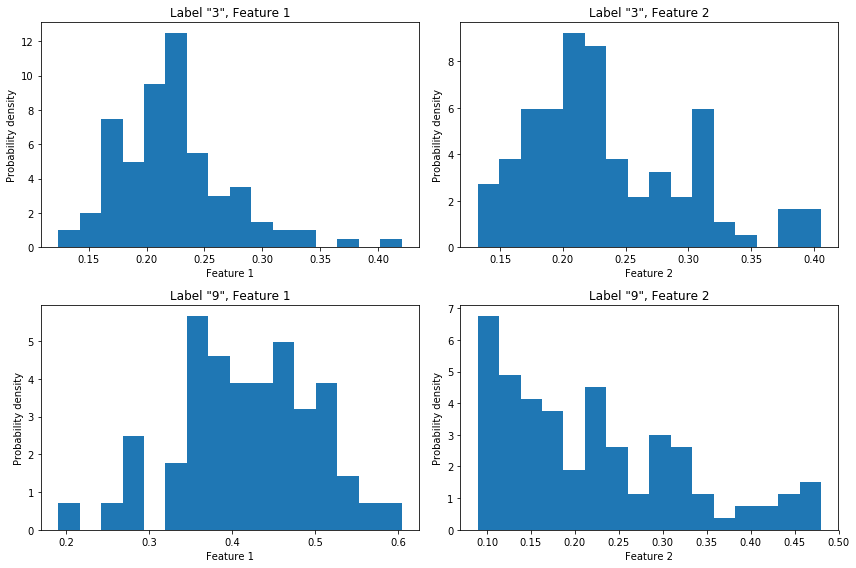

In [79]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
plot_histogram(histograms2f, binning2f, 0,0, axes[0,0])
plot_histogram(histograms2f, binning2f, 0,1, axes[0,1])
plot_histogram(histograms2f, binning2f, 1,0, axes[1,0])
plot_histogram(histograms2f, binning2f, 1,1, axes[1,1])
axes[0,0].set_title('Label "3", Feature 1')
axes[0,1].set_title('Label "3", Feature 2')
axes[1,0].set_title('Label "9", Feature 1')
axes[1,1].set_title('Label "9", Feature 2')
fig.tight_layout()

### Decision boundaries

In [80]:
# create grid in feature space
feature1_range = (0.1, 0.65)
feature2_range = (0.05, 0.6)
x = np.linspace(*feature1_range, 200)
y = np.linspace(*feature2_range, 200)
xv, yv = np.meshgrid(x, y)
grid = np.column_stack([xv.reshape(40000), yv.reshape(40000)])
# classify grid using nearest mean
prediction = predict_naive_bayes(grid, histograms2f, binning2f).reshape(200,200)

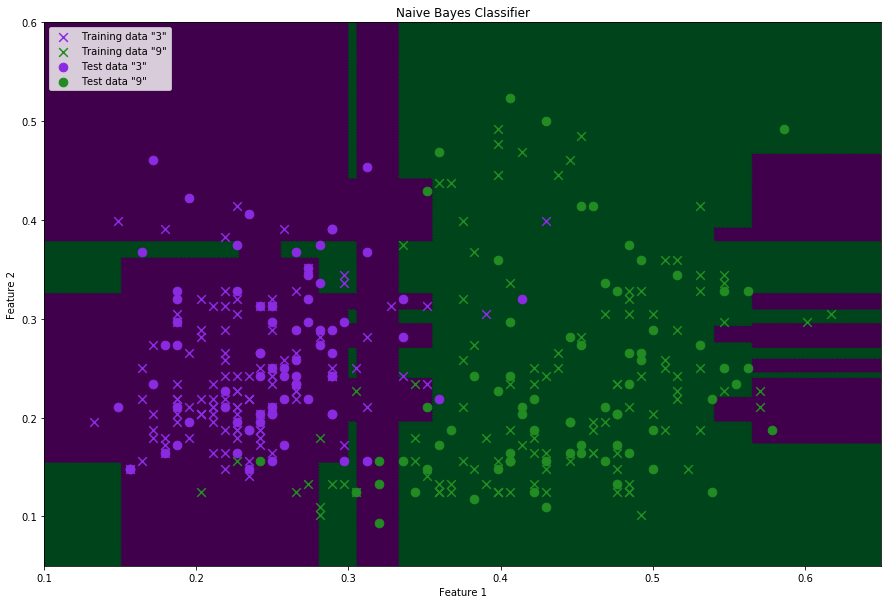

In [38]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.axis(feature1_range + feature2_range)
ax.scatter(xv, yv, c=prediction, cmap='PRGn')
ax.scatter(x_train2f[y_train2f==3,0], x_train2f[y_train2f==3,1], marker='x',
           label='Training data "3"', color='blueviolet', s=75)
ax.scatter(x_train2f[y_train2f==9,0], x_train2f[y_train2f==9,1], marker='x',
           label='Training data "9"', color='forestgreen', s=75)
ax.scatter(x_test2f[y_test2f==3,0], x_test2f[y_test2f==3,1], marker='o',
           label='Test data "3"', color='blueviolet', s=75)
ax.scatter(x_test2f[y_test2f==9,0], x_test2f[y_test2f==9,1], marker='o',
           label='Test data "9"', color='forestgreen', s=75)
ax.set_title("Naive Bayes Classifier")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend(loc='upper left');

### Confusion matrix

In [16]:
confusion_matrix(predicted2f, y_test2f, True);

Truth/Predicted,3,9
3,67,8
9,7,64


### Performance Evaluation

In [85]:
# Calculate performance using 10-fold cross validation
errors2f = []
errors_train2f = []
for train, test in kf.split(x_features, y_labels):
    histograms, binning = fit_naive_bayes(x_features[train], y_labels[train])
    pred_test = predict_naive_bayes(x_features[test], histograms, binning)
    compare_test = pred_test == y_labels[test]
    errors2f.append(1 - np.sum(compare_test) / len(compare_test))
    
    # calculate error on training data
    pred_train = predict_naive_bayes(x_features[train], histograms, binning)
    compare_train = (pred_train == y_labels[train])
    errors_train2f.append(1 - np.sum(compare_train) / len(compare_train))

error2f = (np.mean(errors2f), np.std(errors2f))
error_train2f = (np.mean(errors_train2f), np.std(errors_train2f))
print(f"Naive Bayes Classifier (2 features) mean error rate (10-fold cross validation): " + \
      f"{error2f[0]:.3f}+-{error2f[1]:.3f}")
print(f"Naive Bayes Classifier (2 features) training error rate (10-fold cross validation): " + \
      f"{error_train2f[0]:.3f}+-{error_train2f[1]:.3f}")

Naive Bayes Classifier (2 Features) mean error rate (10-fold cross validation): 0.077+-0.041
Naive Bayes Classifier (2 Features) training error rate (10-fold cross validation): 0.072+-0.009


# Test with all 64 pixels as features

In [112]:
x_train64f, x_test64f, y_train64f, y_test64f = train_test_split(x_data, y_labels, test_size=0.4, random_state=RANDOMSEED)
histograms64f, binning64f = fit_naive_bayes(x_train64f, y_train64f, bincount=8)
predicted64f = predict_naive_bayes(x_test64f, histograms64f, binning64f)

### Confusion matrix

In [114]:
confusion_matrix(predicted64f, y_test64f, True);

Truth/Predicted,3,9
3,75,75
9,71,71


### Performance evaluation

In [116]:
# Calculate performance using 10-fold cross validation
errors64f = []
errors_train64f = []
for train, test in kf.split(x_data, y_labels):
    histograms, binning = fit_naive_bayes(x_data[train], y_labels[train], bincount=8)
    pred_test = predict_naive_bayes(x_data[test], histograms, binning)
    compare_test = pred_test == y_labels[test]
    errors64f.append(1 - np.sum(compare_test) / len(compare_test))
    
    # calculate error on training data
    pred_train = predict_naive_bayes(x_data[train], histograms, binning)
    compare_train = (pred_train == y_labels[train])
    errors_train64f.append(1 - np.sum(compare_train) / len(compare_train))

error64f = (np.mean(errors64f), np.std(errors64f))
error_train64f = (np.mean(errors_train64f), np.std(errors_train64f))
print(f"Naive Bayes Classifier (all pixels) mean error rate (10-fold cross validation): " + \
      f"{error64f[0]:.3f}+-{error64f[1]:.3f}")
print(f"Naive Bayes Classifier (all pixels) training error rate (10-fold cross validation): " + \
      f"{error_train64f[0]:.3f}+-{error_train64f[1]:.3f}")

Naive Bayes Classifier (all pixels) mean error rate (10-fold cross validation): 0.496+-0.061
Naive Bayes Classifier (all pixels) training error rate (10-fold cross validation): 0.496+-0.007
